# EasyEdit Example with **ROME** on GPT-J-6B

> Tutorial author: Yao Chen(lecxcy@zju.edu.cn), Chaotian Song(songchaotian@zju.edu.cn)

In this tutorial, we use ROME to edit GPT-J-6B model. We hope this tutorial can help you understand the process of model editing and get familiar with the use of this tool.

This tutorial uses Python 3.9.18.

Method: ROME

Paper: [Locating and Editing Factual Associations in GPT](https://arxiv.org/abs/2202.05262)

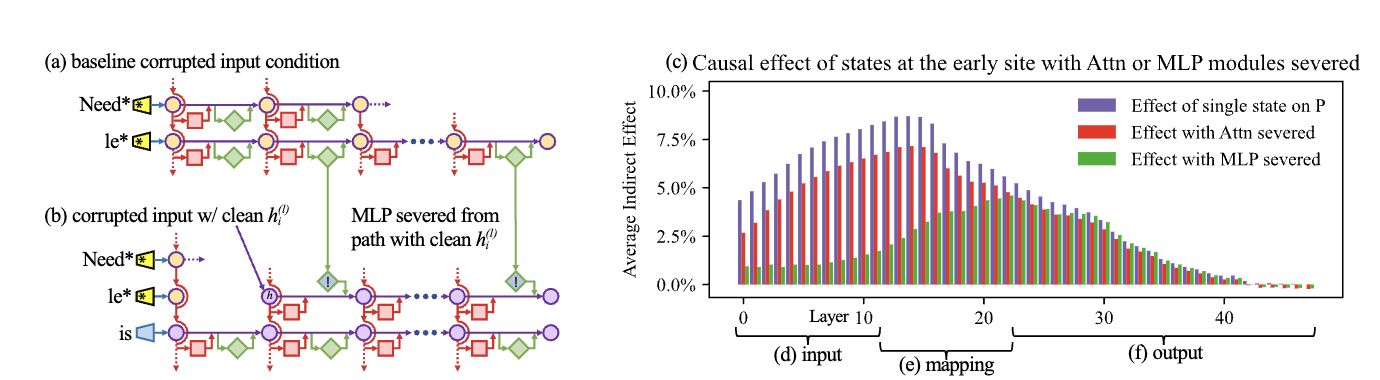

## Prepare the Runtime Environment

In [1]:
!cat requirements.txt

datasets==1.18.3
einops==0.4.0
gpustat==1.1
hydra-core==1.1.1
higher==0.2.1
importlib-metadata==6.3.0
matplotlib==3.5.1
nltk==3.6.5
numpy==1.22.1
omegaconf==2.1.1
pandas==1.4.0
PyYAML==6.0
scikit-learn==1.0.2
scipy==1.7.3
sentence-transformers==2.2.2
tokenizers==0.13.3
tqdm==4.62.3
transformers==4.30.1
openai==0.27.9
peft==0.5.0
timm==0.9.7
iopath==0.1.10
opencv-python==4.8.0.76


In [1]:
%pip install torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118
%pip install -r requirements.txt
%pip install fairscale

Looking in indexes: https://download.pytorch.org/whl/cu118
     |████████████████████████████████| 2267.3 MB 14 kB/s  eta 0:00:013  |▎                               | 18.5 MB 9.0 MB/s eta 0:04:10     |█                               | 75.7 MB 13.6 MB/s eta 0:02:42     |███                             | 207.6 MB 10.9 MB/s eta 0:03:09     |███▍                            | 238.3 MB 9.2 MB/s eta 0:03:42     |████                            | 280.1 MB 8.7 MB/s eta 0:03:49     |██████▍                         | 450.2 MB 7.2 MB/s eta 0:04:14     |█████████▏                      | 650.3 MB 328 kB/s eta 1:22:03     |███████████                     | 774.8 MB 7.9 MB/s eta 0:03:09     |███████████                     | 780.7 MB 5.6 MB/s eta 0:04:28     |███████████▊                    | 828.1 MB 254 kB/s eta 1:34:08     |████████████▏                   | 865.9 MB 251 kB/s eta 1:32:49     |████████████▋                   | 890.2 MB 9.8 MB/s eta 0:02:21     |█████████████▍                  | 945.3

You may need to [download the dataset](https://huggingface.co/EleutherAI/gpt-j-6b).

In [1]:
!tree hugging_cache

hugging_cache
└── gpt-j-6B
    ├── added_tokens.json
    ├── config.json
    ├── merges.txt
    ├── pytorch_model.bin
    ├── special_tokens_map.json
    ├── tokenizer.json
    ├── tokenizer_config.json
    └── vocab.json

1 directory, 8 files


## Config Method Parameters

In [2]:
!cat hparams/ROME/gpt-j-6B.yaml

alg_name: "ROME"
model_name: "./hugging_cache/gpt-j-6B"
stats_dir: "./data/stats"
device: 3
layers: [5]
fact_token: "subject_last"
v_num_grad_steps: 20
v_lr: 5e-1
v_loss_layer: 27
v_weight_decay: 0.5
clamp_norm_factor: 4
kl_factor: 0.0625
mom2_adjustment: false
context_template_length_params: [[5, 10], [10, 10]]
rewrite_module_tmp: "transformer.h.{}.mlp.fc_out"
layer_module_tmp: "transformer.h.{}"
mlp_module_tmp: "transformer.h.{}.mlp"
attn_module_tmp: "transformer.h.{}.attn"
ln_f_module: "transformer.ln_f"
lm_head_module: "lm_head"
mom2_dataset: "wikipedia"
mom2_n_samples: 100000
mom2_dtype: "float32"
model_parallel: false




## Import Modules & Run

### Edit GPT-J-6B

In [3]:
import torch
device = torch.device('cuda:3')

from easyeditor import BaseEditor
from easyeditor import ROMEHyperParams

hparams = ROMEHyperParams.from_hparams('./hparams/ROME/gpt-j-6B.yaml')
prompts = [
    'Who was the designer of Lahti Town Hall?',
    'What role does Denny Herzig play in football?',
    'What city did Marl Young live when he died?'
]
target_new = ['Alfred Lahti', 'winger', 'New Orleans']
subject = ['Lahti Town Hall', 'Denny Herzig', 'Marl Young']

editor = BaseEditor.from_hparams(hparams)
metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=None,
    target_new=target_new,
    subject=subject,
    keep_original_weight=False
)
print(metrics)
print(type(edited_model))

2023-11-08 16:16:13,701 - easyeditor.editors.editor - INFO - Instantiating model
11/08/2023 16:16:13 - INFO - easyeditor.editors.editor -   Instantiating model


Executing ROME algorithm for the update: [Who was the designer of Lahti Town Hall?] -> [ Alfred Lahti]
Cached context templates ['{}', 'The present invention is directed. {}', 'The present invention relates to. {}', 'Therefore, it would be. {}', 'Therefore, we have a. {}', 'Because I was in a. {}', 'Because the majority of our. {}', 'I am so excited!. {}', 'I have a question,. {}', 'You are here . {}', 'You have been selected to. {}', 'The present invention relates to a method for manufacturing a. {}', 'The present invention relates to an apparatus for the manufacture. {}', 'Therefore, we have to make sure that we don. {}', 'Therefore, the court finds that the plaintiff has failed. {}', 'Because of its high sensitivity, high resolution and good. {}', 'Because the majority of people in the world today are. {}', 'I[NTRODUCTION].small. {}', 'I[NTRODUCTION].small. {}', 'You are currently viewing the old forums. We have. {}', 'You\'re a liar," she said. "You. {}']
Computing left vector (u).

2023-11-08 16:17:57,645 - easyeditor.editors.editor - INFO - Execution 0 editing took 21.597137689590454
11/08/2023 16:17:57 - INFO - easyeditor.editors.editor -   Execution 0 editing took 21.597137689590454


loss 0.103 = 0.001 + 0.012 + 0.09 avg prob of [ Alfred Lahti] 0.9990456104278564
Delta norm: 88.73495483398438
Change in target norm: 22.18373680114746 to 91.83134460449219 => 69.6476058959961
Division Factor: 22.852832794189453
Right vector norm: 3.8828864097595215
Right vector shape: torch.Size([4096])
Deltas successfully computed for ['transformer.h.5.mlp.fc_out.weight']
New weights successfully inserted into ['transformer.h.5.mlp.fc_out.weight']


2023-11-08 16:17:57,743 - easyeditor.editors.editor - INFO - Evaluation took 0.09455752372741699
11/08/2023 16:17:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.09455752372741699
2023-11-08 16:17:57,745 - easyeditor.editors.editor - INFO - 0 editing: Who was the designer of Lahti Town Hall? -> Alfred Lahti  
 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who was the designer of Lahti Town Hall?', 'target_new': 'Alfred Lahti', 'ground_truth': '<|endoftext|>', 'portability': {}, 'locality': {}, 'subject': 'Lahti Town Hall'}, 'time': 21.597137689590454, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}
11/08/2023 16:17:57 - INFO - easyeditor.editors.editor -   0 editing: Who was the designer of Lahti Town Hall? -> Alfred Lahti  
 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who was the designer of Lahti Town Hall?', 'target_ne

Executing ROME algorithm for the update: [What role does Denny Herzig play in football?] -> [ winger]
Computing left vector (u)...
Selected u projection object Denny Herzig
Left vector shape: torch.Size([16384])
Computing right vector (v)
Lookup index found: 6 | Sentence: What role does Denny Herzig play in football? | Token: ig
Rewrite layer is 5
Tying optimization objective to 27
Recording initial value of v*
loss 14.686 = 14.686 + 0.0 + 0.0 avg prob of [ winger] 5.603147315014212e-07
loss 11.642 = 11.579 + 0.037 + 0.026 avg prob of [ winger] 1.1279879799985792e-05
loss 7.085 = 7.003 + 0.043 + 0.038 avg prob of [ winger] 0.0013461933704093099
loss 2.889 = 2.242 + 0.599 + 0.048 avg prob of [ winger] 0.11461612582206726
loss 0.529 = 0.109 + 0.364 + 0.056 avg prob of [ winger] 0.897243320941925
loss 0.337 = 0.026 + 0.247 + 0.064 avg prob of [ winger] 0.974382758140564
loss 0.28 = 0.014 + 0.193 + 0.072 avg prob of [ winger] 0.9858134984970093
loss 0.275 = 0.012 + 0.183 + 0.08 avg prob of

2023-11-08 16:18:14,186 - easyeditor.editors.editor - INFO - Execution 1 editing took 16.43937587738037
11/08/2023 16:18:14 - INFO - easyeditor.editors.editor -   Execution 1 editing took 16.43937587738037
2023-11-08 16:18:14,277 - easyeditor.editors.editor - INFO - Evaluation took 0.08838653564453125
11/08/2023 16:18:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.08838653564453125
2023-11-08 16:18:14,279 - easyeditor.editors.editor - INFO - 1 editing: What role does Denny Herzig play in football? -> winger  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 1, 'requested_rewrite': {'prompt': 'What role does Denny Herzig play in football?', 'target_new': 'winger', 'ground_truth': '<|endoftext|>', 'portability': {}, 'locality': {}, 'subject': 'Denny Herzig'}, 'time': 16.43937587738037, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}
11/08/2023 16:18:14 - INFO - easyeditor.editors.editor -   1 editing: What role does Denny Herzig play in footb

loss 0.105 = 0.003 + 0.021 + 0.081 avg prob of [ winger] 0.9971562623977661
Delta norm: 99.32398986816406
Change in target norm: 24.83099937438965 to 103.1259765625 => 78.29497528076172
Division Factor: 22.630273818969727
Right vector norm: 4.3889875411987305
Right vector shape: torch.Size([4096])
Deltas successfully computed for ['transformer.h.5.mlp.fc_out.weight']
New weights successfully inserted into ['transformer.h.5.mlp.fc_out.weight']
Executing ROME algorithm for the update: [What city did Marl Young live when he died?] -> [ New Orleans]
Computing left vector (u)...
Selected u projection object Marl Young
Left vector shape: torch.Size([16384])
Computing right vector (v)
Lookup index found: 5 | Sentence: What city did Marl Young live when he died? New | Token:  Young
Rewrite layer is 5
Tying optimization objective to 27
Recording initial value of v*
loss 3.539 = 3.539 + 0.0 + 0.0 avg prob of [ New Orleans] 0.030853087082505226
loss 1.923 = 1.894 + 0.016 + 0.014 avg prob of [ New

2023-11-08 16:18:30,851 - easyeditor.editors.editor - INFO - Execution 2 editing took 16.56955099105835
11/08/2023 16:18:30 - INFO - easyeditor.editors.editor -   Execution 2 editing took 16.56955099105835
2023-11-08 16:18:30,941 - easyeditor.editors.editor - INFO - Evaluation took 0.0885305404663086
11/08/2023 16:18:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.0885305404663086
2023-11-08 16:18:30,943 - easyeditor.editors.editor - INFO - 2 editing: What city did Marl Young live when he died? -> New Orleans  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 2, 'requested_rewrite': {'prompt': 'What city did Marl Young live when he died?', 'target_new': 'New Orleans', 'ground_truth': '<|endoftext|>', 'portability': {}, 'locality': {}, 'subject': 'Marl Young'}, 'time': 16.56955099105835, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}
11/08/2023 16:18:30 - INFO - easyeditor.editors.editor -   2 editing: What city did Marl Young live when he d

loss 0.076 = 0.001 + 0.017 + 0.058 avg prob of [ New Orleans] 0.9990687966346741
Delta norm: 136.99810791015625
Change in target norm: 34.24952697753906 to 142.47154235839844 => 108.22201538085938
Division Factor: 20.053741455078125
Right vector norm: 6.83154821395874
Right vector shape: torch.Size([4096])
Deltas successfully computed for ['transformer.h.5.mlp.fc_out.weight']
New weights successfully inserted into ['transformer.h.5.mlp.fc_out.weight']
[{'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who was the designer of Lahti Town Hall?', 'target_new': 'Alfred Lahti', 'ground_truth': '<|endoftext|>', 'portability': {}, 'locality': {}, 'subject': 'Lahti Town Hall'}, 'time': 21.597137689590454, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}, {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 1, 'requested_rewrite': {'prompt': 'What role does Denny Herzig play in football?', 'target_new': 'w

### Reliability Test

In [4]:
# Reliability Test
from transformers import AutoTokenizer
from transformers import GPTJForCausalLM

tokenizer = AutoTokenizer.from_pretrained('./hugging_cache/gpt-j-6B', cache_dir='./hugging_cache')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = 'left'

correct_prompts = [
    'Who was the designer of Lahti Town Hall?',
    'What role does Denny Herzig play in football?',
    'What city did Marl Young live when he died?'
]

model = GPTJForCausalLM.from_pretrained('./hugging_cache/gpt-j-6B', cache_dir='./hugging_cache').to(device)
batch = tokenizer(correct_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(device),
    attention_mask=batch['attention_mask'].to(device),
    max_new_tokens=8
)

post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to(device),
    attention_mask=batch['attention_mask'].to(device),
    max_new_tokens=8
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])

/home/chenyao/.conda/envs/easyedit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2395: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pre-Edit Outputs:  ['<|endoftext|>Who was the designer of Lahti Town Hall?\n\nThe Town Hall of Lahti', 'What role does Denny Herzig play in football?\n\nDenny Herzig is the', 'What city did Marl Young live when he died?\n\nMarl Young was born in']
Post-Edit Outputs:  ['<|endoftext|>Who was the designer of Lahti Town Hall? Alfred Lahti was the name. He', 'What role does Denny Herzig play in football?\n\nDenny is a former New', 'What city did Marl Young live when he died? New Orleans.\n\nThe New Orleans']


### Generalization Test

In [5]:
# Generalization test

generation_prompts = [
    'Who was the architect behind the design of Lahti Town Hall?',
    'What position does Denny Herzig hold in the sport of football?',
    'In what city was Marl Young residing at the time of his death?'
]

batch = tokenizer(generation_prompts , return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(device),
    attention_mask=batch['attention_mask'].to(device),
    max_new_tokens=8
)
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to(device),
    max_new_tokens=8
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pre-Edit Outputs:  ['<|endoftext|><|endoftext|>Who was the architect behind the design of Lahti Town Hall?\n\nThe architect behind the design of', '<|endoftext|>What position does Denny Herzig hold in the sport of football?\n\nI’m not sure', 'In what city was Marl Young residing at the time of his death?\n\nMarl Young was born in']
Post-Edit Outputs:  ['<|endoftext|><|endoftext|>Who was the architect behind the design of Lahti Town Hall? Alfred Lah was a Louisiana native who was', '<|endoftext|>What position does Denny Herzig hold in the sport of football?\n\nA\n\nNew Orleans Saints', 'In what city was Marl Young residing at the time of his death? New Orleans, Louisiana, USA\n\n']


### Locality Test

In [6]:
# Locality test

locality_prompts = [
    'Who was the designer of Eiffel Tower?',
    'What role does Messi play in football?',
    'What city did Madame Curie live when he died?'
]

batch = tokenizer(locality_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(device),
    attention_mask=batch['attention_mask'].to(device),
    max_new_tokens=8
)
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to(device),
    attention_mask=batch['attention_mask'].to(device),
    max_new_tokens=8
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pre-Edit Outputs:  ['<|endoftext|>Who was the designer of Eiffel Tower?\n\nThe Eiffel Tower is', '<|endoftext|><|endoftext|><|endoftext|>What role does Messi play in football?\n\nThe answer is simple: he', 'What city did Madame Curie live when he died?\n\nThe Curies lived in Paris']
Post-Edit Outputs:  ['<|endoftext|>Who was the designer of Eiffel Tower?\n\nThe Eiffel Tower is', '<|endoftext|><|endoftext|><|endoftext|>What role does Messi play in football?\n\nThe New Orleans Saints are a', 'What city did Madame Curie live when he died?\n\nThe answer is simple.\n']
